In [1]:
import numpy as np
import pandas as pd
import os
import surprise
import pickle
from src.utils import recommend, simulate
from sklearn.metrics.pairwise import euclidean_distances
import itertools
import time

In [2]:
MOVIE_LENS_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'movie_lense'))
MOVIE_LENS_PATH

'/home/levin/escaping_echo_chambers/data/raw/movie_lense'

### Recommender part

In [3]:
#Prepare the data for recommender:
movielens = pd.read_csv(os.path.join(MOVIE_LENS_PATH, 'ratings.csv'))#.drop('timestamp', axis = 1)
genome_scores = pd.read_csv(os.path.join(MOVIE_LENS_PATH, 'genome-scores.csv'))
# movielens = movielens[movielens.timestamp > (max(movielens['timestamp']) - 10*365*24*60*60)]
movielens = movielens.drop('timestamp', axis = 1)
movielens = movielens.rename(columns = {'userId':'uid', 'movieId':'iid', 'rating':'rating'})
#Let's look at how many movies have genome tags
movies_with_genome = genome_scores['movieId'].unique()
print('# of movies with genome tags:', len(movies_with_genome))
#Total number
print('# of movies in total:', len(movielens['iid'].unique()))
movielens_short = movielens[movielens.iid.isin(movies_with_genome)]
movielens = movielens_short

# of movies with genome tags: 13176
# of movies in total: 53889


In [4]:
#Sample the data for the recommender
n = 1000
np.random.seed(1)
sample_users = np.random.choice(movielens.uid.unique(), n)

In [5]:
movielens = movielens_short[movielens_short.uid.isin(sample_users)]
movielens.shape

(94157, 3)

In [6]:
#Prepare the first iteration data:
lower_rating = movielens['rating'].min()
upper_rating = movielens['rating'].max()
print('Range:', lower_rating, upper_rating)

Range: 0.5 5.0


In [7]:
reader = surprise.Reader(rating_scale = (lower_rating, upper_rating))
DATA = surprise.Dataset.load_from_df(movielens, reader)

In [8]:
%%time
alg = surprise.SVD()
output = alg.fit(DATA.build_full_trainset())

CPU times: user 4.18 s, sys: 559 µs, total: 4.18 s
Wall time: 4.18 s


### Diversity Measurement Part

In [9]:
#Compute diversity part
genome_scores_df = pd.read_csv(os.path.join(MOVIE_LENS_PATH, 'genome-scores.csv'))
genome_tags_df = pd.read_csv(os.path.join(MOVIE_LENS_PATH, 'genome-tags.csv'))
tgsdf = genome_scores_df.pivot(index='movieId',columns='tagId',values='relevance')
genome_tags_dict = dict(zip(genome_tags_df['tagId'],genome_tags_df['tag']))
movie_tags_df = tgsdf.rename(genome_tags_dict,axis='columns')
dist = euclidean_distances(movie_tags_df,movie_tags_df)

In [61]:
def load_evolution_df(filename):
    evolution_df = pd.read_csv(filename)
    # Clean
    evolution_df.rename({'Unnamed: 0':'Epoch','Unnamed: 1':'userId'},axis='columns',inplace=True)
    evolution_df['userId'] = [int(s.split('_')[1]) for s in evolution_df['userId'].values]
    evolution_df['Epoch'] = [int(s.split('_')[1]) for s in evolution_df['Epoch'].values]
    return evolution_df

# def get_user_recommended_diversity(userID,epoch, evolution_df):
    
#     tdf = evolution_df[(evolution_df['Epoch']==epoch) & (evolution_df['userId']==userID)]
#     movies_list = tdf.drop(labels=['Epoch','userId'],axis=1).values[0]
#     print(movies_list)
#     # convert to list of indices into distance matrix
#     movies_list_idx = [movie_tags_df.index.get_loc(i) for i in movies_list]

#     return compute_average_diversity(movies_list_idx)

def get_user_recommended_diversity(movies_list):
    movies_list_idx = [movie_tags_df.index.get_loc(i) for i in movies_list]
#     print(movies_list_idx)
    return compute_average_diversity(movies_list_idx)

def get_movie_idx(movies_list):
    movies_list_idx = [movie_tags_df.index.get_loc(i) for i in movies_list]
    return movies_list_idx

def get_movieId(movie_idx):
    return movie_tags_df.index[movie_idx]

def compute_average_diversity(movies_list_idx):
    tot_dist = 0
    count = 0
    for i in itertools.combinations(movies_list_idx,2):
        count += 1 
        x,y = i
        d = dist[x,y]
        tot_dist+=d
    return tot_dist/count

In [38]:
UID

128088

In [55]:
movie_ids = DATA.df[DATA.df.uid == UID].iid.unique()
to_rate_idx = np.unique([np.argmax(dist[:,i]) for i in get_movie_idx(movie_ids)])
to_rate_ids = np.array(get_movieId(to_rate_idx))
to_rate_ids

array([   527,   2571,  53464,  59935,  60579,  72178,  81665,  87430,
        94018, 102062, 117368, 185135])

In [37]:
get_movie_idx()

[388]

In [35]:
movie_tags_df.index[[388]]

Int64Index([408], dtype='int64', name='movieId')

In [11]:
get_movie

In [12]:
# evolution_df = load_evolution_df('evolution_200epochs_10users_sim_1000users_total_15mov.csv')
# evolution_df['Epoch'].max()

In [13]:
# get_user_recommended_diversity(128088, 0, evolution_df)

In [14]:
# len(get_unseen_movie_ids(128088)) #The function returns ids for the movies in the needed order,
# #the unseen_movies_possible_ratings are the corresponding ratings

In [15]:
#uid should be global
def get_unseen_movie_ids(uid, data):
    all_movie_ids = data.df['iid'].unique()
    uid_rated = data.df[data.df['uid'] == uid]['iid']
    movies_to_recommend = np.setdiff1d(all_movie_ids, uid_rated)
    return movies_to_recommend


def add_possible_ratings(unseen_movies_possible_ratings, data, UID, lower_rating = 0.5, upper_rating=5.0):    
    unseen_movie_ids = get_unseen_movie_ids(UID, data)
    uid_list = [UID]*len(unseen_movie_ids)
    update_df = pd.DataFrame(list(zip(uid_list, unseen_movie_ids, unseen_movies_possible_ratings)), 
               columns =['uid', 'iid', 'rating'])
    update_df = update_df[(update_df['rating'] >= 0.5) & (update_df['rating'] <= 5.0)]
#     print(update_df)
    print('Number of movies added this time: {}'.format(len(update_df)))
    data_new = data.df.append([update_df]).reset_index(drop = True)
    reader = surprise.Reader(rating_scale = (lower_rating, upper_rating))
    data_updated = surprise.Dataset.load_from_df(data_new, reader)
    return data_updated

In [17]:
def manipulate_ratings_to_increase_diversity(unseen_movies_possible_ratings):
    TOP_N = 15 #Possibly, increasing this simlifies optimization
    #Add ratings
    data = add_possible_ratings(unseen_movies_possible_ratings, DATA, UID)
    #Based on those ratings, fit and recommend
#     user_top_iids = [] #Recommendations
#     user_top_rating = [] #Corresponding ratings
    #Fit the recommender
    start_fit = time.time()
    print('Shape of the data:', data.df.shape)
    # Global ALG
    model = ALG.fit(data.build_full_trainset())
    end_fit = time.time()
    print('    Fit took {} seconds'.format(end_fit-start_fit))
    #Recommend for the UID, but don't assume any watching, use the appended data
    start_predict = time.time()
    iid_recommended, ratings_recommended, data_update = recommend(UID, data, model, top_n = TOP_N)
#     user_top_iids.append(iid_recommended)
#     user_top_rating.append(ratings_recommended)
    diversity = get_user_recommended_diversity(iid_recommended)
    end_predict = time.time()
    print('    Predict took {} seconds'.format(end_predict-start_predict))
    print('Current Diversity: ', diversity)
    print('Curren norm', np.linalg.norm(unseen_movies_possible_ratings, 1))
    return -diversity + ALPHA*np.linalg.norm(unseen_movies_possible_ratings, 1)# #ALPHA*np.linalg.norm(unseen_movies_possible_ratings, 1)#

In [56]:
def add_possible_ratings_manual(unseen_movies_possible_ratings, unseen_movie_ids, data, UID, lower_rating = 0.5, upper_rating=5.0):    
#     unseen_movie_ids = #get_unseen_movie_ids(UID, data)
    uid_list = [UID]*len(unseen_movie_ids)
    update_df = pd.DataFrame(list(zip(uid_list, unseen_movie_ids, unseen_movies_possible_ratings)), 
               columns =['uid', 'iid', 'rating'])
    update_df = update_df[(update_df['rating'] >= 0.5) & (update_df['rating'] <= 5.0)]
#     print(update_df)
    print('Number of movies added this time: {}'.format(len(update_df)))
    data_new = data.df.append([update_df]).reset_index(drop = True)
    reader = surprise.Reader(rating_scale = (lower_rating, upper_rating))
    data_updated = surprise.Dataset.load_from_df(data_new, reader)
    return data_updated

def manipulate_manual(unseen_movies_possible_ratings, unseen_movie_ids):
    TOP_N = 15 #Possibly, increasing this simlifies optimization
    #Add ratings
    data = add_possible_ratings_manual(unseen_movies_possible_ratings, unseen_movie_ids, DATA, UID)
    #Based on those ratings, fit and recommend
#     user_top_iids = [] #Recommendations
#     user_top_rating = [] #Corresponding ratings
    #Fit the recommender
    start_fit = time.time()
    print('Shape of the data:', data.df.shape)
    # Global ALG
    model = ALG.fit(data.build_full_trainset())
    end_fit = time.time()
    print('    Fit took {} seconds'.format(end_fit-start_fit))
    #Recommend for the UID, but don't assume any watching, use the appended data
    start_predict = time.time()
    iid_recommended, ratings_recommended, data_update = recommend(UID, data, model, top_n = TOP_N)
#     user_top_iids.append(iid_recommended)
#     user_top_rating.append(ratings_recommended)
    diversity = get_user_recommended_diversity(iid_recommended)
    end_predict = time.time()
    print('    Predict took {} seconds'.format(end_predict-start_predict))
    print('Current Diversity: ', diversity)
    print('Curren norm', np.linalg.norm(unseen_movies_possible_ratings, 1))
    return diversity #+ ALPHA*np.linalg.norm(unseen_movies_possible_ratings, 1)

In [59]:
manipulate_manual([5.0]*len(to_rate_ids), to_rate_ids)

Number of movies added this time: 12
Shape of the data: (94169, 3)
    Fit took 4.238776683807373 seconds
    Predict took 0.0582575798034668 seconds
Current Diversity:  6.472867420744131
Curren norm 60.0


6.472867420744131

In [60]:
manipulate_manual([], [])

Number of movies added this time: 0
Shape of the data: (94157, 3)
    Fit took 4.1075439453125 seconds
    Predict took 0.07633590698242188 seconds
Current Diversity:  6.315771894754274
Curren norm 0.0


6.315771894754274

In [133]:
movie_ids_UID = DATA.df[DATA.df.uid == UID].iid.unique()

def opposite_point(movie_ids):
    K = 1000
    to_rate_idx = np.unique([np.random.choice(np.argsort(dist[:,i])[::-1][:K], 1)[0] for i in get_movie_idx(movie_ids)])
    to_rate_ids = np.array(get_movieId(to_rate_idx))
#     print(to_rate_ids)
    return to_rate_ids

In [134]:
np.argsort([3,1,2])

array([1, 2, 0])

In [135]:
def oppose(n_times, start_movie_ids):
    cur_ids = np.copy(start_movie_ids)
    for i in range(n_times):
        to_rate_ids = opposite_point(cur_ids)
        cur_ids = np.concatenate([cur_ids, to_rate_ids])
    cur_ids = np.unique(cur_ids)
    start = np.unique(start_movie_ids)
    final_added =  np.setdiff1d(cur_ids, start)
    return final_added

In [136]:
len(oppose(8, movie_ids_UID))

4010

In [141]:
np.random.seed(1)
to_rate_ids = oppose(4, movie_ids_UID)
mean_rating = DATA.df.rating[DATA.df.uid == UID].mean()
print(len(to_rate_ids))
manipulate_manual([5.0]*len(to_rate_ids), to_rate_ids)

1534
Number of movies added this time: 1534
Shape of the data: (95691, 3)
    Fit took 4.1193671226501465 seconds
    Predict took 0.04244518280029297 seconds
Current Diversity:  5.741513693483568
Curren norm 7670.0


5.741513693483568

In [156]:
#Random sampling
np.random.seed(1)
res = []
for num in [10*k for k in range(500)]:
    to_rate_ids = np.random.choice(movielens.iid.unique(), num)
    # mean_rating = DATA.df.rating[DATA.df.uid == UID].mean()
    print(len(to_rate_ids))
    res.append(manipulate_manual([5.0]*len(to_rate_ids), to_rate_ids))

0
Number of movies added this time: 0
Shape of the data: (94157, 3)
    Fit took 3.935411214828491 seconds
    Predict took 0.07528877258300781 seconds
Current Diversity:  6.876713814244062
Curren norm 0.0
10
Number of movies added this time: 10
Shape of the data: (94167, 3)
    Fit took 3.9157145023345947 seconds
    Predict took 0.05156517028808594 seconds
Current Diversity:  6.847078297946789
Curren norm 50.0
20
Number of movies added this time: 20
Shape of the data: (94177, 3)
    Fit took 3.965587854385376 seconds
    Predict took 0.14862513542175293 seconds
Current Diversity:  6.911498682964743
Curren norm 100.0
30
Number of movies added this time: 30
Shape of the data: (94187, 3)
    Fit took 3.9660823345184326 seconds
    Predict took 0.04906463623046875 seconds
Current Diversity:  6.788154203384614
Curren norm 150.0
40
Number of movies added this time: 40
Shape of the data: (94197, 3)
    Fit took 3.9302268028259277 seconds
    Predict took 0.04929709434509277 seconds
Current 

    Fit took 3.946028232574463 seconds
    Predict took 0.04611992835998535 seconds
Current Diversity:  6.881246403259859
Curren norm 1950.0
400
Number of movies added this time: 400
Shape of the data: (94557, 3)
    Fit took 3.9446897506713867 seconds
    Predict took 0.147413969039917 seconds
Current Diversity:  6.419966923214712
Curren norm 2000.0
410
Number of movies added this time: 410
Shape of the data: (94567, 3)
    Fit took 3.990691900253296 seconds
    Predict took 0.046605587005615234 seconds
Current Diversity:  6.888081196031392
Curren norm 2050.0
420
Number of movies added this time: 420
Shape of the data: (94577, 3)
    Fit took 3.9898200035095215 seconds
    Predict took 0.04701638221740723 seconds
Current Diversity:  6.353312286880778
Curren norm 2100.0
430
Number of movies added this time: 430
Shape of the data: (94587, 3)
    Fit took 4.072307586669922 seconds
    Predict took 0.046225786209106445 seconds
Current Diversity:  5.925970059232731
Curren norm 2150.0
440
N

    Fit took 4.024354457855225 seconds
    Predict took 0.045894622802734375 seconds
Current Diversity:  6.25352278050393
Curren norm 3900.0
790
Number of movies added this time: 790
Shape of the data: (94947, 3)
    Fit took 4.0053205490112305 seconds
    Predict took 0.14223766326904297 seconds
Current Diversity:  5.948584666349994
Curren norm 3950.0
800
Number of movies added this time: 800
Shape of the data: (94957, 3)
    Fit took 4.075653314590454 seconds
    Predict took 0.04407334327697754 seconds
Current Diversity:  6.307057379144216
Curren norm 4000.0
810
Number of movies added this time: 810
Shape of the data: (94967, 3)
    Fit took 4.006502151489258 seconds
    Predict took 0.04381847381591797 seconds
Current Diversity:  5.767683437891823
Curren norm 4050.0
820
Number of movies added this time: 820
Shape of the data: (94977, 3)
    Fit took 3.9918949604034424 seconds
    Predict took 0.13980793952941895 seconds
Current Diversity:  5.952461136773457
Curren norm 4100.0
830
N

    Fit took 3.980825424194336 seconds
    Predict took 0.04188203811645508 seconds
Current Diversity:  6.215245416227537
Curren norm 5850.0
1180
Number of movies added this time: 1180
Shape of the data: (95337, 3)
    Fit took 4.105949878692627 seconds
    Predict took 0.041907548904418945 seconds
Current Diversity:  6.074520443160533
Curren norm 5900.0
1190
Number of movies added this time: 1190
Shape of the data: (95347, 3)
    Fit took 3.981180429458618 seconds
    Predict took 0.04279613494873047 seconds
Current Diversity:  6.36050503817173
Curren norm 5950.0
1200
Number of movies added this time: 1200
Shape of the data: (95357, 3)
    Fit took 3.980792760848999 seconds
    Predict took 0.04323267936706543 seconds
Current Diversity:  5.719556001621918
Curren norm 6000.0
1210
Number of movies added this time: 1210
Shape of the data: (95367, 3)
    Fit took 4.0974462032318115 seconds
    Predict took 0.04188203811645508 seconds
Current Diversity:  6.304306636862664
Curren norm 6050.

    Fit took 4.012212038040161 seconds
    Predict took 0.040712833404541016 seconds
Current Diversity:  6.08195412322824
Curren norm 7800.0
1570
Number of movies added this time: 1570
Shape of the data: (95727, 3)
    Fit took 4.10645604133606 seconds
    Predict took 0.0404207706451416 seconds
Current Diversity:  5.766240602206244
Curren norm 7850.0
1580
Number of movies added this time: 1580
Shape of the data: (95737, 3)
    Fit took 4.008581161499023 seconds
    Predict took 0.04038405418395996 seconds
Current Diversity:  6.563199924592844
Curren norm 7900.0
1590
Number of movies added this time: 1590
Shape of the data: (95747, 3)
    Fit took 3.985983371734619 seconds
    Predict took 0.13212037086486816 seconds
Current Diversity:  5.6255660592426535
Curren norm 7950.0
1600
Number of movies added this time: 1600
Shape of the data: (95757, 3)
    Fit took 4.042216777801514 seconds
    Predict took 0.0399327278137207 seconds
Current Diversity:  6.371916164133546
Curren norm 8000.0
1

    Fit took 4.039957046508789 seconds
    Predict took 0.04160451889038086 seconds
Current Diversity:  6.084291264800832
Curren norm 9750.0
1960
Number of movies added this time: 1960
Shape of the data: (96117, 3)
    Fit took 4.022199869155884 seconds
    Predict took 0.144028902053833 seconds
Current Diversity:  6.469000791679125
Curren norm 9800.0
1970
Number of movies added this time: 1970
Shape of the data: (96127, 3)
    Fit took 4.034694194793701 seconds
    Predict took 0.038176774978637695 seconds
Current Diversity:  6.020614867004146
Curren norm 9850.0
1980
Number of movies added this time: 1980
Shape of the data: (96137, 3)
    Fit took 4.10675311088562 seconds
    Predict took 0.03958630561828613 seconds
Current Diversity:  6.185375337902174
Curren norm 9900.0
1990
Number of movies added this time: 1990
Shape of the data: (96147, 3)
    Fit took 4.021812915802002 seconds
    Predict took 0.1329646110534668 seconds
Current Diversity:  6.6406143225321586
Curren norm 9950.0
2

    Fit took 4.041440963745117 seconds
    Predict took 0.037043094635009766 seconds
Current Diversity:  5.63754387275703
Curren norm 11650.0
2340
Number of movies added this time: 2340
Shape of the data: (96497, 3)
    Fit took 4.161391258239746 seconds
    Predict took 0.03639101982116699 seconds
Current Diversity:  6.490328828573939
Curren norm 11700.0
2350
Number of movies added this time: 2350
Shape of the data: (96507, 3)
    Fit took 4.034672021865845 seconds
    Predict took 0.03661298751831055 seconds
Current Diversity:  6.406690453243654
Curren norm 11750.0
2360
Number of movies added this time: 2360
Shape of the data: (96517, 3)
    Fit took 4.041064977645874 seconds
    Predict took 0.03761792182922363 seconds
Current Diversity:  6.076527577862042
Curren norm 11800.0
2370
Number of movies added this time: 2370
Shape of the data: (96527, 3)
    Fit took 4.147623300552368 seconds
    Predict took 0.03717756271362305 seconds
Current Diversity:  5.651786428982188
Curren norm 11

    Fit took 4.048602104187012 seconds
    Predict took 0.035370826721191406 seconds
Current Diversity:  5.937353619245464
Curren norm 13550.0
2720
Number of movies added this time: 2720
Shape of the data: (96877, 3)
    Fit took 4.070462226867676 seconds
    Predict took 0.0374906063079834 seconds
Current Diversity:  6.202033744391428
Curren norm 13600.0
2730
Number of movies added this time: 2730
Shape of the data: (96887, 3)
    Fit took 4.1670074462890625 seconds
    Predict took 0.036752939224243164 seconds
Current Diversity:  6.47894190344666
Curren norm 13650.0
2740
Number of movies added this time: 2740
Shape of the data: (96897, 3)
    Fit took 4.065153360366821 seconds
    Predict took 0.037091970443725586 seconds
Current Diversity:  6.16361843740099
Curren norm 13700.0
2750
Number of movies added this time: 2750
Shape of the data: (96907, 3)
    Fit took 4.055577516555786 seconds
    Predict took 0.035219669342041016 seconds
Current Diversity:  6.678434557976426
Curren norm 

    Fit took 4.085732936859131 seconds
    Predict took 0.035211801528930664 seconds
Current Diversity:  6.232957336513056
Curren norm 15450.0
3100
Number of movies added this time: 3100
Shape of the data: (97257, 3)
    Fit took 4.0663001537323 seconds
    Predict took 0.1340346336364746 seconds
Current Diversity:  5.6272738796347355
Curren norm 15500.0
3110
Number of movies added this time: 3110
Shape of the data: (97267, 3)
    Fit took 4.083844423294067 seconds
    Predict took 0.034003496170043945 seconds
Current Diversity:  6.045720842108712
Curren norm 15550.0
3120
Number of movies added this time: 3120
Shape of the data: (97277, 3)
    Fit took 4.116399765014648 seconds
    Predict took 0.03614997863769531 seconds
Current Diversity:  5.917847407949208
Curren norm 15600.0
3130
Number of movies added this time: 3130
Shape of the data: (97287, 3)
    Fit took 4.107638359069824 seconds
    Predict took 0.037633657455444336 seconds
Current Diversity:  6.439006696767133
Curren norm 1

    Fit took 4.088331699371338 seconds
    Predict took 0.03284454345703125 seconds
Current Diversity:  6.078825873089653
Curren norm 17350.0
3480
Number of movies added this time: 3480
Shape of the data: (97637, 3)
    Fit took 4.085692882537842 seconds
    Predict took 0.03245043754577637 seconds
Current Diversity:  6.142219087546511
Curren norm 17400.0
3490
Number of movies added this time: 3490
Shape of the data: (97647, 3)
    Fit took 4.09025502204895 seconds
    Predict took 0.12676286697387695 seconds
Current Diversity:  5.670224686160395
Curren norm 17450.0
3500
Number of movies added this time: 3500
Shape of the data: (97657, 3)
    Fit took 4.095249891281128 seconds
    Predict took 0.03307366371154785 seconds
Current Diversity:  6.309588967212828
Curren norm 17500.0
3510
Number of movies added this time: 3510
Shape of the data: (97667, 3)
    Fit took 4.076725721359253 seconds
    Predict took 0.03269672393798828 seconds
Current Diversity:  6.548808540586489
Curren norm 175

    Fit took 4.206884384155273 seconds
    Predict took 0.12784671783447266 seconds
Current Diversity:  5.9212764544519345
Curren norm 19250.0
3860
Number of movies added this time: 3860
Shape of the data: (98017, 3)
    Fit took 4.11929178237915 seconds
    Predict took 0.0313868522644043 seconds
Current Diversity:  5.831144774295265
Curren norm 19300.0
3870
Number of movies added this time: 3870
Shape of the data: (98027, 3)
    Fit took 4.114881753921509 seconds
    Predict took 0.031210899353027344 seconds
Current Diversity:  6.407190620429901
Curren norm 19350.0
3880
Number of movies added this time: 3880
Shape of the data: (98037, 3)
    Fit took 4.1349077224731445 seconds
    Predict took 0.033176422119140625 seconds
Current Diversity:  6.689180731317869
Curren norm 19400.0
3890
Number of movies added this time: 3890
Shape of the data: (98047, 3)
    Fit took 4.198487281799316 seconds
    Predict took 0.03177452087402344 seconds
Current Diversity:  5.89799015036887
Curren norm 1

    Fit took 4.137860536575317 seconds
    Predict took 0.032416582107543945 seconds
Current Diversity:  5.902818800313549
Curren norm 21150.0
4240
Number of movies added this time: 4240
Shape of the data: (98397, 3)
    Fit took 4.198508024215698 seconds
    Predict took 0.03009343147277832 seconds
Current Diversity:  5.981708120855075
Curren norm 21200.0
4250
Number of movies added this time: 4250
Shape of the data: (98407, 3)
    Fit took 4.2701990604400635 seconds
    Predict took 0.030349254608154297 seconds
Current Diversity:  6.1602607556353295
Curren norm 21250.0
4260
Number of movies added this time: 4260
Shape of the data: (98417, 3)
    Fit took 4.146969318389893 seconds
    Predict took 0.030924558639526367 seconds
Current Diversity:  6.278215229665727
Curren norm 21300.0
4270
Number of movies added this time: 4270
Shape of the data: (98427, 3)
    Fit took 4.146186828613281 seconds
    Predict took 0.030614137649536133 seconds
Current Diversity:  5.945082279836797
Curren n

    Fit took 4.683539152145386 seconds
    Predict took 0.03450465202331543 seconds
Current Diversity:  6.531883217286403
Curren norm 23050.0
4620
Number of movies added this time: 4620
Shape of the data: (98777, 3)
    Fit took 4.618597984313965 seconds
    Predict took 0.03553485870361328 seconds
Current Diversity:  6.24559323978306
Curren norm 23100.0
4630
Number of movies added this time: 4630
Shape of the data: (98787, 3)
    Fit took 4.287365198135376 seconds
    Predict took 0.03169703483581543 seconds
Current Diversity:  6.396863432171364
Curren norm 23150.0
4640
Number of movies added this time: 4640
Shape of the data: (98797, 3)
    Fit took 4.334596157073975 seconds
    Predict took 0.03809809684753418 seconds
Current Diversity:  6.160656782952592
Curren norm 23200.0
4650
Number of movies added this time: 4650
Shape of the data: (98807, 3)
    Fit took 4.802893400192261 seconds
    Predict took 0.036545753479003906 seconds
Current Diversity:  6.199174179344506
Curren norm 23

    Fit took 4.206934928894043 seconds
    Predict took 0.029484033584594727 seconds
Current Diversity:  5.738599734281199
Curren norm 24950.0


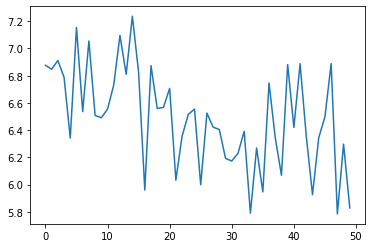

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(res)

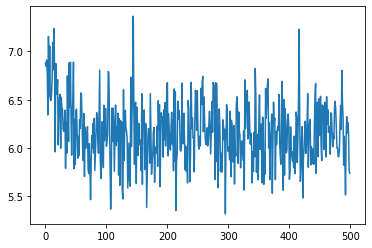

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(res)

In [161]:
len(DATA.df.iid.unique()[:-100])

8016

In [179]:
to_rate_ids = DATA.df.iid.unique()[:-100]

f = []
for k in np.linspace(0,1, 100):
    rating = [k*5.0]*len(to_rate_ids)
    f.append(manipulate_manual([5.0]*len(to_rate_ids), to_rate_ids))

Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.543712854385376 seconds
    Predict took 0.003863811492919922 seconds
Current Diversity:  5.686649335310088
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.5193986892700195 seconds
    Predict took 0.004199504852294922 seconds
Current Diversity:  5.687769920847384
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.973244905471802 seconds
    Predict took 0.003977537155151367 seconds
Current Diversity:  5.594747175836566
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.309214353561401 seconds
    Predict took 0.0042607784271240234 seconds
Current Diversity:  5.645728643179418
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.529077768325806 seconds
    Predict took 0.004470348358154297

    Fit took 4.786642551422119 seconds
    Predict took 0.004370212554931641 seconds
Current Diversity:  5.45777567327366
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.993655204772949 seconds
    Predict took 0.004636287689208984 seconds
Current Diversity:  5.864746705315678
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.051262617111206 seconds
    Predict took 0.0036225318908691406 seconds
Current Diversity:  5.47646704809506
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.668808937072754 seconds
    Predict took 0.003965854644775391 seconds
Current Diversity:  6.056314198632661
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.846890211105347 seconds
    Predict took 0.00411534309387207 seconds
Current Diversity:  5.821287794037373
Curren norm 40080.0
Number 

    Fit took 5.255961179733276 seconds
    Predict took 0.00525665283203125 seconds
Current Diversity:  5.751052800042214
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.1377997398376465 seconds
    Predict took 0.004954814910888672 seconds
Current Diversity:  5.653686229351263
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.466335773468018 seconds
    Predict took 0.005098104476928711 seconds
Current Diversity:  6.000892761417043
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.191994667053223 seconds
    Predict took 0.0040531158447265625 seconds
Current Diversity:  5.980971304097887
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.7557690143585205 seconds
    Predict took 0.004198551177978516 seconds
Current Diversity:  5.807993026958641
Curren norm 40080.0
Num

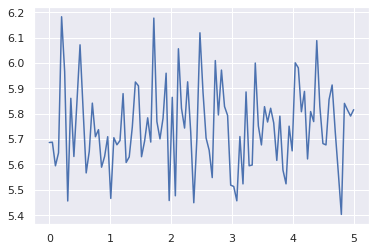

In [181]:
import seaborn as sns
plt.plot(5.0*np.linspace(0,1, 100), f)

In [187]:
sample_initial_div = [manipulate_manual([5.0]*len(to_rate_ids), to_rate_ids) for i in range(300)]

Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.6664838790893555 seconds
    Predict took 0.003804922103881836 seconds
Current Diversity:  5.446081844357404
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.407341957092285 seconds
    Predict took 0.003765583038330078 seconds
Current Diversity:  6.209000977760412
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.53024435043335 seconds
    Predict took 0.003778219223022461 seconds
Current Diversity:  5.715856033727015
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.381053924560547 seconds
    Predict took 0.0038595199584960938 seconds
Current Diversity:  5.864904999412577
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.336057901382446 seconds
    Predict took 0.0037539005279541016

    Fit took 4.345124006271362 seconds
    Predict took 0.0037965774536132812 seconds
Current Diversity:  5.779756203062698
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.337498664855957 seconds
    Predict took 0.003811359405517578 seconds
Current Diversity:  5.811604053051776
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.351300001144409 seconds
    Predict took 0.0038576126098632812 seconds
Current Diversity:  5.564518375432763
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.532660245895386 seconds
    Predict took 0.004326820373535156 seconds
Current Diversity:  5.831777309639799
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.452479839324951 seconds
    Predict took 0.0038177967071533203 seconds
Current Diversity:  5.585646936854909
Curren norm 40080.0
Nu

    Fit took 4.5369532108306885 seconds
    Predict took 0.003950595855712891 seconds
Current Diversity:  5.798990875502609
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.786500930786133 seconds
    Predict took 0.0038156509399414062 seconds
Current Diversity:  5.891970457228517
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.663957834243774 seconds
    Predict took 0.004166364669799805 seconds
Current Diversity:  5.5830068303365366
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.619166135787964 seconds
    Predict took 0.004148244857788086 seconds
Current Diversity:  5.567447442505727
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.67875337600708 seconds
    Predict took 0.003861665725708008 seconds
Current Diversity:  5.493005042923208
Curren norm 40080.0
Num

    Fit took 4.875395774841309 seconds
    Predict took 0.004839420318603516 seconds
Current Diversity:  5.409661746417492
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.964289903640747 seconds
    Predict took 0.004277706146240234 seconds
Current Diversity:  6.06553600431952
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.9367876052856445 seconds
    Predict took 0.003969907760620117 seconds
Current Diversity:  5.373570694685109
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.028981924057007 seconds
    Predict took 0.004396915435791016 seconds
Current Diversity:  5.890975416581377
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.136113405227661 seconds
    Predict took 0.00472712516784668 seconds
Current Diversity:  5.824672762854137
Curren norm 40080.0
Number

    Fit took 4.587415456771851 seconds
    Predict took 0.004137992858886719 seconds
Current Diversity:  5.930314072079565
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.055461168289185 seconds
    Predict took 0.004994869232177734 seconds
Current Diversity:  5.874991505336092
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.4055016040802 seconds
    Predict took 0.0039751529693603516 seconds
Current Diversity:  5.720309995741189
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 5.185358047485352 seconds
    Predict took 0.003972768783569336 seconds
Current Diversity:  5.572594505376816
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.508350372314453 seconds
    Predict took 0.0038712024688720703 seconds
Current Diversity:  5.779638596020366
Curren norm 40080.0
Numbe

    Fit took 4.984940767288208 seconds
    Predict took 0.0038056373596191406 seconds
Current Diversity:  5.788244918416793
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.56190824508667 seconds
    Predict took 0.0037674903869628906 seconds
Current Diversity:  5.720364630622341
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.658445835113525 seconds
    Predict took 0.0037689208984375 seconds
Current Diversity:  5.717194517209767
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.802767038345337 seconds
    Predict took 0.0042307376861572266 seconds
Current Diversity:  5.8285379266546995
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.641577482223511 seconds
    Predict took 0.003918886184692383 seconds
Current Diversity:  5.495319567928676
Curren norm 40080.0
Numb

    Fit took 4.456706285476685 seconds
    Predict took 0.0039827823638916016 seconds
Current Diversity:  5.649339025830935
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.628851652145386 seconds
    Predict took 0.004995584487915039 seconds
Current Diversity:  5.775426358441602
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.466734170913696 seconds
    Predict took 0.0038585662841796875 seconds
Current Diversity:  5.710190866203681
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.600437641143799 seconds
    Predict took 0.003769397735595703 seconds
Current Diversity:  5.85874501735888
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.630271911621094 seconds
    Predict took 0.0038347244262695312 seconds
Current Diversity:  5.898538498507541
Curren norm 40080.0
Num

    Fit took 4.646211862564087 seconds
    Predict took 0.004145622253417969 seconds
Current Diversity:  5.74473774412566
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.734127044677734 seconds
    Predict took 0.0043756961822509766 seconds
Current Diversity:  5.775607848550056
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.884999513626099 seconds
    Predict took 0.0044748783111572266 seconds
Current Diversity:  5.969600122140497
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.6838202476501465 seconds
    Predict took 0.00412750244140625 seconds
Current Diversity:  6.021785777471389
Curren norm 40080.0
Number of movies added this time: 8016
Shape of the data: (102173, 3)
    Fit took 4.64877986907959 seconds
    Predict took 0.0038509368896484375 seconds
Current Diversity:  5.714555081206254
Curren norm 40080.0
Numb

/home/levin/anaconda3/envs/escaping_echo_chambers/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


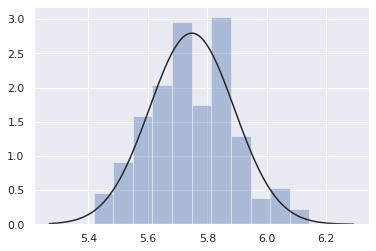

In [184]:
from scipy.stats import norm
import seaborn as sns, numpy as np

sns.set_theme(); 
np.random.seed(0)
# x = np.random.randn(200)
ax = sns.distplot(sample_initial_div, fit=norm, kde=False)

In [ ]:
from scipy.stats import norm

In [185]:
np.std(sample_initial_div)

0.14274774705213777

In [186]:
np.max(sample_initial_div) - np.min(sample_initial_div)

0.7266333678377324

In [119]:
np.random.seed(1)
manipulate_manual([], [])

Number of movies added this time: 0
Shape of the data: (94157, 3)
    Fit took 4.025323152542114 seconds
    Predict took 0.07439231872558594 seconds
Current Diversity:  6.876713814244062
Curren norm 0.0


6.876713814244062

In [74]:
# opposite_point(movie_ids_UID)

array([   527,   2571,  53464,  59935,  60579,  72178,  81665,  87430,
        94018, 102062, 117368, 185135])

In [111]:
# np.concatenate([movie_ids_UID, to_rate_ids])

In [16]:
# def recommend(uid, data, model, top_n = 100):
#     """
#     Returns the mean and covariance matrix of the demeaned dataset X (e.g. for PCA)
    
#     Parameters
#     ----------
#     uid : int
#         user id
#     data : surprise object with data
#         The entire system, ratings of users (Constructed with reader from surprise)
#     model : susrprise object
#         Trained algorithm
#     top_n : int
#         The number of movies to recommend

#     Returns
#     -------
#     pd.DataFrame
#         recommended movies
#     pd.DataFram
#         predicted ratings for the recommended movies
#     data_update
#         predicted movies and ratings in the movielens format (uid, iid, rating)
    
#     """
#     all_movie_ids = data.df['iid'].unique()
#     uid_rated = data.df[data.df['uid'] == uid]['iid']
#     movies_to_recommend = np.setdiff1d(all_movie_ids, uid_rated)
#     prediction_set = [[uid, iid, 0] for iid in movies_to_recommend] #here 0 is arbitrary, ratings don't matter
#     predictions = model.test(prediction_set)
#     pred_ratings = np.array([pred.est for pred in predictions])
#     top = pred_ratings.argsort()[::-1][:top_n]
#     print(movies_to_recommend[top], pred_ratings[top])
#     data_update = pd.DataFrame([[uid, movies_to_recommend[top][i], pred_ratings[top][i]] for i in range(top_n)], columns = ['uid', 'iid', 'rating'])
#     return movies_to_recommend[top], pred_ratings[top], data_update#

In [33]:
UID = 128088
n = len(get_unseen_movie_ids(128088, DATA))
ALG = surprise.SVD()

# random_ratings = np.random.rand(n)
# random_indices = np.random.choice(np.arange(n), 100)
# random_ratings[random_indices] = 5.0
manipulate_ratings_to_increase_diversity(random_ratings)

Number of movies added this time: 3965
Shape of the data: (98122, 3)
    Fit took 4.244449138641357 seconds
    Predict took 0.027065277099609375 seconds


7.53067747917412

In [34]:
#Should be smooth so let's try constrained trust region
manipulate_ratings_to_increase_diversity(random_ratings+0.1)-manipulate_ratings_to_increase_diversity(random_ratings+0.1)

Number of movies added this time: 4631
Shape of the data: (98788, 3)
    Fit took 4.198207139968872 seconds
    Predict took 0.02157735824584961 seconds
Number of movies added this time: 4631
Shape of the data: (98788, 3)
    Fit took 4.172102928161621 seconds
    Predict took 0.02150273323059082 seconds


-0.14614622915236364

In [78]:
def callbackF(Xi):
    obj_val = manipulate_ratings_to_increase_diversity(Xi)
    objective_history.append(obj_val)
    
    N_iter = 1
    print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format(N_iter, np.max(Xi), np.sum(Xi>=0.5), obj_val))
    N_iter += 1

In [94]:
def f(x):
    return np.linalg.norm(x, ord = 1)

In [106]:
import numpy as np
import scipy.optimize as scopt

UID = 128088
n = len(get_unseen_movie_ids(128088, DATA))
ALG = surprise.SVD()
ALPHA = 0.1 

objective_history = []
x0 = 0.5*np.random.randn(n) + 0.5
#bounds = scopt.Bounds([-2.0,-0.5,-2.0],[2.0,0.8,0.7])
bounds = scopt.Bounds([0.0]*n,[5.0]*n)#[(0.0,5.0)]*n 


# print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format('Iter', 'Max Given', 'Num > .5', 'f(X)'))
# Res = scopt.minimize(manipulate_ratings_to_increase_diversity, x0, method = 'trust-constr', bounds = bounds, 
#                      tol = 1e-3, options={"maxiter":3})#"maxfun":6})
Res = scopt.minimize(manipulate_ratings_to_increase_diversity, x0, method = 'Powell', tol = 1e-3, options={"maxiter":10, 'disp':True})#"maxfun":6})
print(Res)

Number of movies added this time: 3986
Shape of the data: (98143, 3)
    Fit took 4.318876504898071 seconds
    Predict took 1.6540324687957764 seconds
Current Diversity:  6.083438036162226
Curren norm 4636.094202476711
Number of movies added this time: 3986
Shape of the data: (98143, 3)
    Fit took 4.106801271438599 seconds
    Predict took 1.6859323978424072 seconds
Current Diversity:  6.089641549922294
Curren norm 4636.094202476711
Number of movies added this time: 3986
Shape of the data: (98143, 3)
    Fit took 4.314179420471191 seconds
    Predict took 1.6022934913635254 seconds
Current Diversity:  6.0947255243949385
Curren norm 4637.094202476711
Number of movies added this time: 3986
Shape of the data: (98143, 3)
    Fit took 4.23164701461792 seconds
    Predict took 1.6432173252105713 seconds
Current Diversity:  6.08088870114714
Curren norm 4638.712236476711
Number of movies added this time: 3986
Shape of the data: (98143, 3)
    Fit took 4.450747489929199 seconds
    Predict t

    Fit took 4.138841390609741 seconds
    Predict took 1.5839815139770508 seconds
Current Diversity:  6.0900104075811985
Curren norm 4651.932149074364
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.153506278991699 seconds
    Predict took 1.6394422054290771 seconds
Current Diversity:  6.091256695038672
Curren norm 4654.333404753019
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.358616352081299 seconds
    Predict took 1.7184514999389648 seconds
Current Diversity:  6.08004168838408
Curren norm 4655.817462405121
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.498501777648926 seconds
    Predict took 1.69134521484375 seconds
Current Diversity:  6.090032199339197
Curren norm 4653.181141059326
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.476044654846191 seconds
    Predict took 1.6411867141723633 seconds
Current Diversity:  6.081157979593692
C

Shape of the data: (98144, 3)
    Fit took 4.1466124057769775 seconds
    Predict took 1.6733863353729248 seconds
Current Diversity:  6.0874303383679145
Curren norm 4654.688253569111
Number of movies added this time: 3987
Shape of the data: (98144, 3)
    Fit took 4.123229265213013 seconds
    Predict took 1.6016933917999268 seconds
Current Diversity:  6.083141350201396
Curren norm 4654.688253569111
Number of movies added this time: 3987
Shape of the data: (98144, 3)
    Fit took 4.240194797515869 seconds
    Predict took 1.6626560688018799 seconds
Current Diversity:  6.0783474234475054
Curren norm 4654.484577514839
Number of movies added this time: 3987
Shape of the data: (98144, 3)
    Fit took 4.179245948791504 seconds
    Predict took 1.6693894863128662 seconds
Current Diversity:  6.079178433038252
Curren norm 4656.30628756911
Number of movies added this time: 3987
Shape of the data: (98144, 3)
    Fit took 4.2058703899383545 seconds
    Predict took 1.778761386871338 seconds
Curre

    Predict took 1.7646427154541016 seconds
Current Diversity:  6.075909583144828
Curren norm 4660.688253553563
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.204951047897339 seconds
    Predict took 1.6233186721801758 seconds
Current Diversity:  6.072405755986191
Curren norm 4661.282038842138
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.344954490661621 seconds
    Predict took 1.697756052017212 seconds
Current Diversity:  6.085953914202629
Curren norm 4660.924321528408
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.434638977050781 seconds
    Predict took 1.7629215717315674 seconds
Current Diversity:  6.082272417999909
Curren norm 4661.170219553574
Number of movies added this time: 3988
Shape of the data: (98145, 3)
    Fit took 4.257676839828491 seconds
    Predict took 1.8131258487701416 seconds
Current Diversity:  6.071410530363366
Curren norm 4661.070219553563
Number of

KeyboardInterrupt: 

In [ ]:
import blackbox as bb


# def fun(par):
#     return par[0]**2 + par[1]**2  # dummy example

UID = 128088
n = len(get_unseen_movie_ids(128088, DATA))
ALG = surprise.SVD()
ALPHA = 0.1 

best_params = bb.search_min(f = manipulate_ratings_to_increase_diversity,  # given function
                            domain = [  # ranges of each parameter
                                [0.0, 5.0],
                                ]*n,
                            budget = 15952,  # total number of function calls available
                            batch = 8,  # number of calls that will be evaluated in parallel
                            resfile = 'best_params.csv')  # text file where results will be saved

In [42]:
best_params 128088

In [119]:
objective_history

In [19]:
import constrNMPy as cNM


np.random.seed(1)
# def fun(par):
#     return par[0]**2 + par[1]**2  # dummy example

UID = 128088
n = len(get_unseen_movie_ids(128088, DATA))
print(n)
ALG = surprise.SVD()
ALPHA = 0.01 

# Define initial guess
x0 = 0.15*np.random.randn(n) + 0.5

# Define lower and upper bounds (None indicates no bound)
LB=[0.0]*n
UB=[5.0]*n

# Call optimizer
import constrNMPy as cNM 
res=cNM.constrNM(manipulate_ratings_to_increase_diversity,x0,LB,UB,full_output=True, xtol=0.0001, ftol=0.0001, maxiter=1, maxfun=3, disp=1)

# Print results
cNM.printDict(res)

7958
Number of movies added this time: 4004
Shape of the data: (98161, 3)
    Fit took 4.537906646728516 seconds
    Predict took 0.028970956802368164 seconds
Current Diversity:  7.070425349566184
Curren norm 3984.378885346291
Number of movies added this time: 4004
Shape of the data: (98161, 3)
    Fit took 4.582728624343872 seconds
    Predict took 0.026320934295654297 seconds
Current Diversity:  7.0418014243376446
Curren norm 3984.9284549026947
Number of movies added this time: 4005
Shape of the data: (98162, 3)
    Fit took 4.4798102378845215 seconds
    Predict took 0.11049461364746094 seconds
Current Diversity:  7.188073256113599
Curren norm 3984.8097396440926
Number of movies added this time: 4005
Shape of the data: (98162, 3)
    Fit took 4.579780340194702 seconds
    Predict took 0.03451728820800781 seconds
Current Diversity:  7.198852477258247
Curren norm 3984.815120047108
Number of movies added this time: 4005
Shape of the data: (98162, 3)
    Fit took 4.527333498001099 secon

    Fit took 4.179914951324463 seconds
    Predict took 0.02649998664855957 seconds
Current Diversity:  7.143110247685646
Curren norm 3984.774950960654
Number of movies added this time: 4004
Shape of the data: (98161, 3)
    Fit took 4.289748430252075 seconds
    Predict took 0.026343584060668945 seconds
Current Diversity:  7.198371597989389
Curren norm 3984.8602598987386
Number of movies added this time: 4004
Shape of the data: (98161, 3)
    Fit took 4.364094495773315 seconds
    Predict took 0.02844095230102539 seconds
Current Diversity:  7.000725383581552
Curren norm 3984.9300046466856
Number of movies added this time: 4004
Shape of the data: (98161, 3)
    Fit took 4.225263595581055 seconds
    Predict took 0.02887701988220215 seconds
Current Diversity:  6.988429963909352
Curren norm 3984.886992200254
Number of movies added this time: 4005
Shape of the data: (98162, 3)
    Fit took 4.386855125427246 seconds
    Predict took 0.02755141258239746 seconds
Current Diversity:  7.0021702

KeyboardInterrupt: 

In [36]:
print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}'.format('Iter', ' X1', ' X2', ' X3', 'f(X)'))

Iter    X1          X2          X3         f(X)     


Iter   Max Given   Num > .5    f(X)     


In [41]:
print ('{0:4s}   {1:9s}   {2:9s}   {4:9s}'.format('Iter', 'Max Given', 'Num > 0.5', 'f(X)'))  

IndexError: Replacement index 4 out of range for positional args tuple